In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("TA_restaurants_curated.csv", encoding='utf8', index_col=0)

## Data Analysis

In [ ]:
df.head()

,Name,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",1.0,5.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080
1,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",2.0,4.5,$$$$,812.0,"[['Great food and staff', 'just perfect'], ['0...",/Restaurant_Review-g188590-d693419-Reviews-De_...,d693419
2,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",3.0,4.5,$$$$,567.0,"[['Satisfaction', 'Delicious old school restau...",/Restaurant_Review-g188590-d696959-Reviews-La_...,d696959
3,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",4.0,5.0,$$$$,564.0,"[['True five star dinner', 'A superb evening o...",/Restaurant_Review-g188590-d1239229-Reviews-Vi...,d1239229
4,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",5.0,4.5,$$$$,316.0,"[['Best meal.... EVER', 'super food experience...",/Restaurant_Review-g188590-d6864170-Reviews-Li...,d6864170


In [ ]:
df.shape[0]

125527

In [ ]:
df.shape[1]

10

<div class="alert alert-block alert-success">
Let's check for duplicates based on the id and if there are any, we need to remove them.
</div>

In [ ]:
print(df[df.ID_TA.duplicated() == True].ID_TA.count())

201


In [ ]:
df = df.drop_duplicates('ID_TA', keep='first')


<div class="alert alert-block alert-success">
We can remove some of the columns as they do not help in our analysis neither on algorithms nor on explaining the dataset.
</div>

In [ ]:

df = df.drop(['URL_TA', 'ID_TA'], axis = 1)

In [ ]:
df.count()

Name                 125326
City                 125326
Cuisine Style         94047
Ranking              115710
Rating               115734
Price Range           77574
Number of Reviews    108022
Reviews              115745
dtype: int64

<div class="alert alert-block alert-success">
Now, let's check the number of missing values in the included columns and the percentage of them.
</div>

In [ ]:
df[df.columns[df.isnull().any()]].isnull().sum()

Cuisine Style        31279
Ranking               9616
Rating                9592
Price Range          47752
Number of Reviews    17304
Reviews               9581
dtype: int64

In [ ]:
df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0]

Cuisine Style        24.958109
Ranking               7.672789
Rating                7.653639
Price Range          38.102229
Number of Reviews    13.807191
Reviews               7.644862
dtype: float64

<div class="alert alert-block alert-success">
The columns that we will work with for our sentiment analysis are the Review and the Rating. So, we need to remove the rows that contain nan variables in these specific columns.
</div>

In [ ]:
df = df.dropna(subset=['Rating', 'Reviews', 'Number of Reviews'])

In [ ]:
df[df.columns[df.isnull().any()]].isnull().sum()

Cuisine Style    22630
Ranking             28
Price Range      33873
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108021 entries, 0 to 1592
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Name               108021 non-null  object 
 1   City               108021 non-null  object 
 2   Cuisine Style      85391 non-null   object 
 3   Ranking            107993 non-null  float64
 4   Rating             108021 non-null  float64
 5   Price Range        74148 non-null   object 
 6   Number of Reviews  108021 non-null  float64
 7   Reviews            108021 non-null  object 
dtypes: float64(3), object(5)
memory usage: 7.4+ MB


In [ ]:
df = df.drop(['Name', 'City', 'Cuisine Style', 'Ranking', 'Price Range', 'Number of Reviews'], axis = 1)

In [ ]:

df.head()

,Rating,Reviews
0,5.0,"[['Just like home', 'A Warm Welcome to Wintry ..."
1,4.5,"[['Great food and staff', 'just perfect'], ['0..."
2,4.5,"[['Satisfaction', 'Delicious old school restau..."
3,5.0,"[['True five star dinner', 'A superb evening o..."
4,4.5,"[['Best meal.... EVER', 'super food experience..."


In [ ]:
df.Rating.value_counts()

 4.0    37259
 4.5    31300
 3.5    19701
 5.0     8023
 3.0     7457
 2.5     2718
 2.0     1025
 1.5      384
 1.0      149
-1.0        5
Name: Rating, dtype: int64

<div class="alert alert-block alert-success">
Replace rows with -1 rating with 0
</div>

In [ ]:
df.Rating.replace(-1, 0, inplace=True)

In [ ]:
df.groupby('Rating').count()

,Reviews
Rating,
0.0,5
1.0,149
1.5,384
2.0,1025
2.5,2718
3.0,7457
3.5,19701
4.0,37259
4.5,31300


In [ ]:
df.Reviews

0       [['Just like home', 'A Warm Welcome to Wintry ...
1       [['Great food and staff', 'just perfect'], ['0...
2       [['Satisfaction', 'Delicious old school restau...
3       [['True five star dinner', 'A superb evening o...
4       [['Best meal.... EVER', 'super food experience...
                              ...                        
1586                    [['Cordon Bleu'], ['10/02/2014']]
1587                                             [[], []]
1588    [["Don't waste your time, go somewhere else!",...
1591    [['Poor quality, small portions, miserable st....
1592                                             [[], []]
Name: Reviews, Length: 108021, dtype: object

<div class="alert alert-block alert-success">
We can see that the reviews are separated by comma and [] which will makes it difficult for our sentiment analysis. So, we have to split them by '] and ['.   
</div>

In [ ]:
all_revs = []
nan = 0
for ind, rev in df['Reviews'].iteritems():
    if type(rev) != float:
        g = rev.split('], [')
        g = g[0][2:].replace('\'', "")
    else:
        g = ""
        nan +=1
    all_revs.append(g)

In [ ]:
df['reviews_only'] = all_revs
df = df.drop(['Reviews'], axis = 1)

In [ ]:
df

,Rating,reviews_only
0,5.0,"Just like home, A Warm Welcome to Wintry Amste..."
1,4.5,"Great food and staff, just perfect"
2,4.5,"Satisfaction, Delicious old school restaurant"
3,5.0,"True five star dinner, A superb evening of fin..."
4,4.5,"Best meal.... EVER, super food experience"
...,...,...
1586,2.0,Cordon Bleu
1587,1.5,
1588,2.0,"""Dont waste your time, go somewhere else!"", Ho..."
1591,1.0,"Poor quality, small portions, miserable st..."


<div class="alert alert-block alert-success">
Let's now consider reviews with rating > 3.0 as positive and reviews with rating < 3.0 as negative. Reviews that rating = 3.0 are neutral and not usefull for our sentiment analysis , so we drop them.
</div>

In [ ]:
df.drop(df[df.Rating == 3.0].index, inplace = True)

In [ ]:
df["Sentiment"] = np.where(df["Rating"] < 3.0, 'neg', 'pos')
df = df.drop(['Rating'], axis = 1)
df.Sentiment = df.Sentiment.astype('category')

In [ ]:
df

,reviews_only,Sentiment
0,"Just like home, A Warm Welcome to Wintry Amste...",pos
1,"Great food and staff, just perfect",pos
2,"Satisfaction, Delicious old school restaurant",pos
3,"True five star dinner, A superb evening of fin...",pos
4,"Best meal.... EVER, super food experience",pos
...,...,...
1580,"Good service, 38 USD for a pizza!! HORRIBLE PR...",neg
1582,"Very amicable owner; Good pizzas, A very helpf...",neg
1585,"Super local eatery, Small and charming place",pos
1586,Cordon Bleu,neg


<div class="alert alert-block alert-success">
At ths point, we will open our second dataset, bring it at the same form as the above one and then concatenate them.
</div>

In [ ]:
df2 = pd.read_csv("greek_reviews.csv", encoding='utf8', index_col=0)

In [ ]:
df2.head()

,GroundTruth,Ratings,Review Date,Review Title,Site
Description,,,,,
I visit this place with my friends. It was very nice restaurant with special italian food and the service exellent.,positive,5,1-Mar-20,The Best Italian Food in Larissa,NaN
"It deserves every star given in Trip Advisor. Delicious plates in a tasty place, served smartly by gently people. Definitely the prime choice for a visitor in Larisa.",positive,5,9-Jan-20,Excellent,NaN
"Great good and value for money. A must visit in larissa also for coffe and tiramisu dessert. Have been there many times, very crowded on sundays.",positive,5,20-Dec-19,Great good!,NaN
"We went with friends. We took seats in the garden. Nice setting, comfortable chairs, polite staff, reasonable prices. \nWe had penne con pollo, papardelle con filettini di vitello and bella casa salads. Everything was delicious. Strongly Recommended!",positive,5,7-Jun-19,"Delicious food, excellent service",NaN
Beautiful and cosy place ! Delicious and big portions ! Congratulations ! Polite and smiling staff ! See you soon ...,positive,5,6-Mar-19,Excellent !,NaN


In [ ]:
df2 = df2.reset_index()

In [ ]:
df2 = df2.drop(['GroundTruth', 'Review Title', 'Site', 'Review Date'], axis = 1)

In [ ]:
df2

,Description,Ratings
0,I visit this place with my friends. It was ver...,5
1,It deserves every star given in Trip Advisor. ...,5
2,Great good and value for money. A must visit i...,5
3,We went with friends. We took seats in the gar...,5
4,Beautiful and cosy place ! Delicious and big p...,5
...,...,...
1035,"Staff was very polite, the music and the ambie...",4
1036,"Nice place very good food, fast service good p...",5
1037,We were about 20 people and they didn't have a...,4
1038,Everything said in the title :)\nWe came to Tr...,5


In [ ]:
df2[df2.columns[df2.isnull().any()]].isnull().sum()

Series([], dtype: float64)

In [ ]:
df2 = df2.drop(df2[df2.Ratings == 3.0].index)

In [ ]:
df2["Sentiment"] = np.where(df2["Ratings"] < 3.0, 'neg', 'pos')
df2 = df2.drop(['Ratings'], axis = 1)
df2.Sentiment = df2.Sentiment.astype('category')

In [ ]:
df2

,Description,Sentiment
0,I visit this place with my friends. It was ver...,pos
1,It deserves every star given in Trip Advisor. ...,pos
2,Great good and value for money. A must visit i...,pos
3,We went with friends. We took seats in the gar...,pos
4,Beautiful and cosy place ! Delicious and big p...,pos
...,...,...
1035,"Staff was very polite, the music and the ambie...",pos
1036,"Nice place very good food, fast service good p...",pos
1037,We were about 20 people and they didn't have a...,pos
1038,Everything said in the title :)\nWe came to Tr...,pos


In [ ]:
df2.columns = ['reviews_only', 'Sentiment']

In [ ]:
df = pd.concat([df,df2])

In [ ]:
df

,reviews_only,Sentiment
0,"Just like home, A Warm Welcome to Wintry Amste...",pos
1,"Great food and staff, just perfect",pos
2,"Satisfaction, Delicious old school restaurant",pos
3,"True five star dinner, A superb evening of fin...",pos
4,"Best meal.... EVER, super food experience",pos
...,...,...
1035,"Staff was very polite, the music and the ambie...",pos
1036,"Nice place very good food, fast service good p...",pos
1037,We were about 20 people and they didn't have a...,pos
1038,Everything said in the title :)\nWe came to Tr...,pos


<div class="alert alert-block alert-success">
As we can see there are some rows of reviews_only that contain empty string so we drop these too.
</div>

In [ ]:
df.reviews_only.replace("", np.nan, inplace=True)

In [ ]:
df[df.columns[df.isnull().any()]].isnull().sum()

reviews_only    7280
dtype: int64

In [ ]:
df = df.dropna(subset = ['reviews_only'])

In [ ]:
df

,reviews_only,Sentiment
0,"Just like home, A Warm Welcome to Wintry Amste...",pos
1,"Great food and staff, just perfect",pos
2,"Satisfaction, Delicious old school restaurant",pos
3,"True five star dinner, A superb evening of fin...",pos
4,"Best meal.... EVER, super food experience",pos
...,...,...
1035,"Staff was very polite, the music and the ambie...",pos
1036,"Nice place very good food, fast service good p...",pos
1037,We were about 20 people and they didn't have a...,pos
1038,Everything said in the title :)\nWe came to Tr...,pos


<div class="alert alert-block alert-success">
Now, for further analysis we will create another column which contains average word length. 
</div>

In [ ]:
def average_words(x):
    words = x.split()
    return sum(len(word) for word in words) / len (words)


df['average_word_length'] = df['reviews_only'].apply(lambda x : average_words(x))

In [ ]:
import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')
len(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

In [ ]:
df['word_count'] = df['reviews_only'].apply(lambda x: len(x.split()))
df['char count'] = df['reviews_only'].apply(lambda x : len(x))
df['stop_word_count'] = df['reviews_only'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))
df['stop_word_rate'] = df['stop_word_count']/ df['word_count']

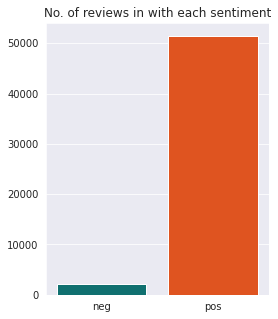

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(4, 5))
sns.countplot(df['Sentiment'], palette=['teal', 'orangered'])
plt.title('No. of reviews in with each sentiment')
plt.xlabel("")
plt.ylabel("")
plt.show()

<div class="alert alert-block alert-success">
We can see that positive reviews are way more than the negative ones. This will cause a problem to the algorithms known as class imbalance problem because they will learn to predict postive values. A good idea might be to drop some of the positive reviews to make the dataset about even.
</div>

In [ ]:
df.replace({'Sentiment':{'pos':1,'neg':-1}},inplace=True)

In [ ]:
df.describe()

,Sentiment,average_word_length,word_count,char count,stop_word_count,stop_word_rate
count,53667.000000,53667.000000,53667.000000,53667.000000,53667.000000,53667.000000
mean,0.917528,5.467127,8.164123,50.038254,1.979373,0.200802
std,0.397674,1.151011,5.007278,28.526491,2.567496,0.151787
min,-1.000000,1.571429,1.000000,2.000000,0.000000,0.000000
25%,1.000000,4.666667,5.000000,34.000000,1.000000,0.090909
50%,1.000000,5.300000,8.000000,47.000000,1.000000,0.200000
75%,1.000000,6.000000,10.000000,60.000000,3.000000,0.307692
max,1.000000,20.000000,45.000000,315.000000,28.000000,1.000000


In [ ]:
df["Sentiment"].value_counts()

 1    51454
-1     2213
Name: Sentiment, dtype: int64

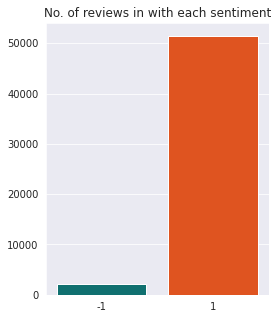

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(4, 5))
sns.countplot(df['Sentiment'], palette=['teal', 'orangered'])
plt.title('No. of reviews in with each sentiment')
plt.xlabel("")
plt.ylabel("")
plt.show()

In [ ]:
df_copy = df.copy()

In [ ]:

from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = df[df['Sentiment']== 1] 
df_minority = df[df['Sentiment']== -1] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 51454, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df = pd.concat([df_minority_upsampled, df_majority])

In [ ]:

class_0 = df[df["Sentiment"]==1]
class_1 = df[df["Sentiment"]==-1]
class_count_0, class_count_1 = df['Sentiment'].value_counts()
print(class_count_0)
print(class_count_1)
class_0_under = class_0.sample(class_count_1)

df = pd.concat([class_0_under, class_1], axis=0)


51454
51454


In [ ]:
df["Sentiment"].value_counts()

-1    51454
 1    51454
Name: Sentiment, dtype: int64

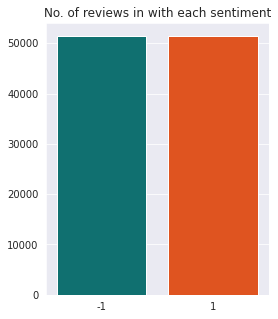

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(4, 5))
sns.countplot(df['Sentiment'], palette=['teal', 'orangered'])
plt.title('No. of reviews in with each sentiment')
plt.xlabel("")
plt.ylabel("")
plt.show()

In [ ]:
df["stop_word_count"].value_counts()

1     26135
0     25110
2     21277
3     13660
4      7911
5      4380
6      1722
7       790
8       317
20      218
12      215
24      192
13      141
9       129
19      102
16       97
15       88
10       63
14       60
18       56
23       55
21       35
22       34
17       32
11       28
25       27
26       21
27        8
28        5
Name: stop_word_count, dtype: int64

In [ ]:
df["word_count"].value_counts()

6     12110
7     12103
8     11126
5     10341
9     10025
4      8610
10     8401
11     6508
3      5576
12     4491
2      3988
13     2693
14     1956
1      1258
15     1173
45      699
16      626
17      235
29      212
31      101
42       85
18       85
36       51
20       49
19       36
34       34
40       29
27       28
30       26
22       25
25       25
28       22
21       21
26       21
44       19
24       19
32       17
33       15
23       14
37       13
38       13
35       12
41       10
39        5
43        2
Name: word_count, dtype: int64

In [ ]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.update(["br", "href"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div class="alert alert-block alert-success">
Let's print a wordcould with the most frequently used words
</div>

In [ ]:
from wordcloud import WordCloud, STOPWORDS
textt = " ".join(x for x in df.reviews_only)
wordcloud = WordCloud(stopwords=stop_words).generate(textt)

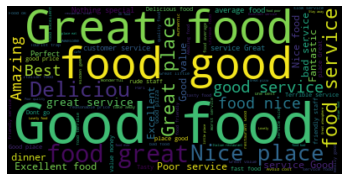

In [ ]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud101.png')
plt.show()

<div class="alert alert-block alert-success">
Now, we need to remove punctuation and stopwards from the text. Also, we make convert all review|s into the lower case.
</div>

In [ ]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"', "<", ">","/", ",", "'", "[", "]"))
    return final

df['reviews_only'] = df['reviews_only'].apply(remove_punctuation)

In [ ]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
#import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

stopword_list=nltk.corpus.stopwords.words('english')

def remove_stopwords(text, is_lower_case=False):
    tokenizer=ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

copied_data=df.copy()
#Apply function on review column
df['reviews_only'] = df['reviews_only'].apply(remove_stopwords)
    

<div class="alert alert-block alert-success">
Afterwards, we perform stemming on hte text wich is a process of f mapping words to their root form.
</div>

In [ ]:
def get_stemmed_text(corpus):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

df["reviews_only"] = get_stemmed_text(df["reviews_only"])

In [ ]:
df = df.reset_index(drop=True)


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['reviews_only']=df['reviews_only'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df

,reviews_only,Sentiment,average_word_length,word_count,char count,stop_word_count,stop_word_rate
0,nice italian great,1,5.666667,3,19,0,0.000000
1,look bland good decent pub go week,1,4.285714,14,73,5,0.357143
2,clean eat 100 % stay away plea,1,5.000000,6,35,0,0.000000
3,friendli staff good late find citi,1,4.500000,8,43,2,0.250000
4,doubl fri chip sit terrac like local,1,4.083333,12,60,5,0.416667
...,...,...,...,...,...,...,...
102903,good asian lunch eateri,-1,5.000000,4,23,0,0.000000
102904,ehh cremat grill,-1,6.333333,3,21,0,0.000000
102905,realli bad servic terribl food,-1,5.800000,5,33,0,0.000000
102906,aw averag - bad way,-1,3.285714,7,29,2,0.285714


# Models

## Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
X_train,X_test,y_train, y_test = train_test_split(df['reviews_only'], df['Sentiment'], test_size=0.25, random_state=30)
cv = KFold(n_splits=5, random_state=1, shuffle=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)


In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
X_train = tf_x_train
X_test = tf_x_test
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
predictions


array([-1, -1, -1, ..., -1,  1,  1])

In [ ]:
from numpy import mean
lr_report=classification_report(y_test,predictions)
print(lr_report)

scores = cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores
score1 = mean(scores)
score1

              precision    recall  f1-score   support

          -1       0.87      0.90      0.88      6205
           1       0.89      0.87      0.88      6295

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



0.8733333333333333

In [ ]:
sentence = ["very good movie", "bad", "awful movie", "not good movie"]
sentence_pred = vectorizer.transform(sentence)
lr.predict(sentence_pred)

array([ 1, -1, -1,  1])

## KNeighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_bow = neigh.fit(X_train,y_train)
print(neigh_bow)

neigh_bow_predict = neigh.predict(X_test)
print(neigh_bow_predict)


#Classification report for bag of words 
neigh_bow_report=classification_report(y_test,neigh_bow_predict)
print(neigh_bow_report)

KNeighborsClassifier(n_neighbors=3)
[-1 -1  1 ... -1 -1 -1]
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98     12893
           1       1.00      0.96      0.98     12834

    accuracy                           0.98     25727
   macro avg       0.98      0.98      0.98     25727
weighted avg       0.98      0.98      0.98     25727



In [ ]:
scores = cross_val_score(neigh, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores
score2 = mean(scores)
score2

0.9773260409280745

In [ ]:
sentence = ["very good movie", "bad", "awful movie", "not good movie"]
sentence_pred = vectorizer.transform(sentence)
neigh.predict(sentence_pred)

array([-1, -1, -1,  1])

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier()
#fitting the svm for bag of words
clf_bow=clf.fit(X_train,y_train)
print(clf_bow)
#fitting the svm for tfidf features

#Predicting the model for bag of words
clf_bow_predict=clf.predict(X_test)
print(clf_bow_predict)


#Classification report for bag of words 
clf_bow_report=classification_report(y_test,clf_bow_predict)
print(clf_bow_report)

#confusion matrix for bag of words
clf_bow=confusion_matrix(y_test,clf_bow_predict)
print(clf_bow)


RandomForestClassifier()
[-1 -1  1 ... -1 -1 -1]
              precision    recall  f1-score   support

          -1       0.99      1.00      1.00     12893
           1       1.00      0.99      1.00     12834

    accuracy                           1.00     25727
   macro avg       1.00      1.00      1.00     25727
weighted avg       1.00      1.00      1.00     25727

[[12890     3]
 [  116 12718]]


In [ ]:
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores
score3 = mean(scores)
score3

0.9953874698527647

In [ ]:
sentence = ["very good movie", "bad", "awful movie", "not good movie"]
sentence_pred = vectorizer.transform(sentence)
clf.predict(sentence_pred)

array([-1, -1,  1,  1])

## Guassian NB

In [ ]:
data = df.sample(frac=0.01,replace=True,random_state=1)

X_train,X_test,y_train, y_test = train_test_split(data['reviews_only'], data['Sentiment'], test_size=0.25, random_state=30)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)
X_train = tf_x_train
X_test = tf_x_test

In [ ]:



from sklearn.naive_bayes import GaussianNB
#training the model
clf = GaussianNB()
#fitting the svm for bag of words
clf_bow=clf.fit(X_train.toarray(),y_train)
print(clf_bow)

clf_bow_predict=clf.predict(X_test.toarray())
print(clf_bow_predict)

#Accuracy score for bag of words
score3=accuracy_score(y_test,clf_bow_predict)
print("clf_bow_score :",score3)

#Classification report for bag of words 
clf_bow_report=classification_report(y_test,clf_bow_predict)
print(clf_bow_report)

cm_bow=confusion_matrix(y_test,clf_bow_predict)
print(cm_bow)


GaussianNB()
[-1 -1 -1 ... -1 -1 -1]
clf_bow_score : 0.616
              precision    recall  f1-score   support

          -1       0.57      0.93      0.71       620
           1       0.81      0.31      0.45       630

    accuracy                           0.62      1250
   macro avg       0.69      0.62      0.58      1250
weighted avg       0.69      0.62      0.58      1250

[[575  45]
 [435 195]]


In [ ]:
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
scores
score4 = mean(scores)
score4 

nan

In [ ]:
sentence = ["very good movie", "bad", "awful movie", "not good movie"]
sentence_pred = vectorizer.transform(sentence)
clf.predict(sentence_pred.toarray())

array([-1, -1, -1, -1])

## SVC

In [ ]:
X_train,X_test,y_train, y_test = train_test_split(data['reviews_only'], data['Sentiment'], test_size=0.25, random_state=30)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)
X_train = tf_x_train
X_test = tf_x_test

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
svm_bow=svm.fit(X_train,y_train)
print(svm_bow)

svm_bow_predict=svm.predict(X_test)
print(svm_bow_predict)


svm_bow_report=classification_report(y_test,svm_bow_predict)
print(svm_bow_report)


SGDClassifier(max_iter=500, random_state=42)
[-1 -1  1 ... -1 -1 -1]
              precision    recall  f1-score   support

          -1       0.87      0.88      0.88     12893
           1       0.88      0.87      0.88     12834

    accuracy                           0.88     25727
   macro avg       0.88      0.88      0.88     25727
weighted avg       0.88      0.88      0.88     25727



In [ ]:
from numpy import mean
scores = cross_val_score(svm, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
scores
score5 = mean(scores)
score5

0.866210724587431

In [ ]:
sentence = ["very good movie", "bad", "awful movie", "not good movie"]
sentence_pred = vectorizer.transform(sentence)
svm.predict(sentence_pred)

array([ 1, -1, -1,  1])

## LSTM

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
data = df.sample(frac=0.2,replace=True,random_state=1)

X_train,X_test,y_train, y_test = train_test_split(data['reviews_only'], data['Sentiment'], test_size=0.25, random_state=30)


In [ ]:

vocab_size = df["word_count"].sum()
oov_tok = "<OOV>"
embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

# convert validation dataset to sequence and pad sequences
validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
# model initialization
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 100)          56713200  
                                                                 
 lstm_5 (LSTM)               (None, 64)                42240     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 56,757,025
Trainable params: 56,757,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 5
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.33)

# predict values
pred = model.predict(validation_padded)

Epoch 1/5
238/238 - 172s - loss: 0.6351 - accuracy: 0.0435 - val_loss: 0.6496 - val_accuracy: 0.0000e+00 - 172s/epoch - 723ms/step
Epoch 2/5
238/238 - 167s - loss: 0.6302 - accuracy: 0.0000e+00 - val_loss: 0.6455 - val_accuracy: 0.0000e+00 - 167s/epoch - 703ms/step
Epoch 3/5
238/238 - 165s - loss: 0.6305 - accuracy: 0.0000e+00 - val_loss: 0.6437 - val_accuracy: 0.0000e+00 - 165s/epoch - 695ms/step
Epoch 4/5
238/238 - 170s - loss: 0.6316 - accuracy: 0.0000e+00 - val_loss: 0.6464 - val_accuracy: 0.0000e+00 - 170s/epoch - 716ms/step
Epoch 5/5
238/238 - 165s - loss: 0.6311 - accuracy: 0.0000e+00 - val_loss: 0.6430 - val_accuracy: 0.0000e+00 - 165s/epoch - 692ms/step


In [ ]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# preict the label
print(model.predict(padded))

[[0.3382358]
 [0.3382358]]


In [ ]:


pred = (pred > 0.5).astype(int)
score5 = accuracy_score(pred, y_test)
score5

0.0

## Autosklearn Classifier

In [ ]:
X_train,X_test,y_train, y_test = train_test_split(df['reviews_only'], df['Sentiment'], test_size=0.25, random_state=30)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)
X_train = tf_x_train
X_test = tf_x_test

In [ ]:
!pip install scikit-learn==0.24.2
import sklearn
!pip show scikit-learn
!pip show auto-sklearn
import autosklearn
from autosklearn.classification import AutoSklearnClassifier
cls = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task = 2*60)
cls.fit(X_train, y_train)
predictions = cls.predict(X_test, y_test)

Name: scikit-learn
Version: 0.24.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, numpy, joblib, threadpoolctl
Required-by: yellowbrick, smac, sklearn, sklearn-pandas, mlxtend, lightgbm, librosa, imbalanced-learn, auto-sklearn
Name: auto-sklearn
Version: 0.14.5
Summary: Automated machine learning.
Home-page: https://automl.github.io/auto-sklearn
Author: Matthias Feurer
Author-email: feurerm@informatik.uni-freiburg.de
License: BSD3
Location: /usr/local/lib/python3.7/dist-packages
Requires: setuptools, threadpoolctl, ConfigSpace, pyrfr, joblib, scikit-learn, distributed, pyyaml, numpy, smac, dask, distro, typing-extensions, liac-arff, scipy, pynisher, pandas
Required-by: 


In [ ]:
predicitons = (predictions > 0.5).astype(int)
score5 = accuracy_score(predictions, y_test)
score5

0.8372

## XGboost Classifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import warnings
warnings.filterwarnings('ignore')

#cross_val_score(XGBClassifier(), X_train, y_train)

xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

scores = cross_val_score(xgbc, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

[04:55:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:56:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [ ]:
sentence = ["very good movie", "bad", "awful movie", "not good movie"]
sentence_pred = vectorizer.transform(sentence)
xgbc.predict(sentence_pred)

array([ 1, -1,  1,  1], dtype=int64)

# Deep Learning Models

## TFIDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0,max_df=1,token_pattern=r'\b\w+\b',ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf = True).fit(X_train)
X_train = tf_transformer.transform(X_train)
X_test = tf_transformer.transform(X_test)

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
lr_report=classification_report(y_test,predictions)
print(lr_report)
from sklearn.metrics import accuracy_score
score1=accuracy_score(y_test,predictions)

print("ACCURACY:",score1)
sentence = ["very good movie", "bad", "awful movie", "not good movie"]
sentence_pred = vectorizer.transform(sentence)
lr.predict(sentence_pred)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       362
           1       0.94      1.00      0.97      5761

    accuracy                           0.94      6123
   macro avg       0.47      0.50      0.48      6123
weighted avg       0.89      0.94      0.91      6123

ACCURACY: 0.9408786542544504


C:\Users\BASILIS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BASILIS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\BASILIS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([1, 1, 1, 1], dtype=int64)

## Bidirectional LSTM

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train,X_test,y_train, y_test = train_test_split(df['reviews_only'], df['Sentiment'], test_size=0.25, random_state=30)


vocab_size = df["word_count"].sum()
oov_tok = "<OOV>"
embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

# convert validation dataset to sequence and pad sequences
validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
# model initialization

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 100)          18882300  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_8 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 18,969,901
Trainable params: 18,969,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_padded, y_train, epochs=5, batch_size=32, verbose=2)

Epoch 1/5
574/574 - 376s - loss: 0.2466 - accuracy: 0.9137
Epoch 2/5
574/574 - 310s - loss: 0.4998 - accuracy: 0.8958
Epoch 3/5
574/574 - 308s - loss: -1.5697e+00 - accuracy: 0.9040
Epoch 4/5
574/574 - 301s - loss: -7.2071e+00 - accuracy: 0.8918
Epoch 5/5
574/574 - 282s - loss: -1.5417e+01 - accuracy: 0.8844


In [ ]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# preict the label
print(model.predict(padded))

pred = (pred > 0.5).astype(int)
score5 = accuracy_score(pred, y_test)
score5

[[1.]
 [0.]]


0.9408786542544504

## Bert Algorithm

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
data = df.sample(frac=0.1,replace=True,random_state=1)

X_train,X_test,y_train, y_test = train_test_split(data['reviews_only'], data['Sentiment'], test_size=0.25, random_state=30)

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
24/24 [==============================] - 365s 15s/step - loss: 0.1930 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/10
24/24 [==============================] - 358s 15s/step - loss: 0.0037 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/10
24/24 [==============================] - 361s 15s/step - loss: -0.0865 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/10
24/24 [==============================] - 359s 15s/step - loss: -0.2155 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/10
24/24 [==============================] - 358s 15s/step - loss: -0.2779 - accuracy: 0.0027 - precision: 1.0000 - recall: 0.0027
Epoch 6/10
24/24 [==============================] - 358s 15s/step - loss: -0.3574 - accuracy: 0.0027 - precision: 1.0000 - recall: 0.0053
Epoch 7/10
24/24 [==============================] - 352s 15s/step - loss: -0.4580 - accuracy: 0.0093 - precision: 1.0000 - rec

In [ ]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 159s 19s/step - loss: -0.5414 - accuracy: 0.0120 - precision: 1.0000 - recall: 0.0400


[-0.5413885116577148, 0.012000000104308128, 1.0, 0.03999999910593033]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
score6 = accuracy_score(y_predicted, y_test)
score5

0.8372